# ASSIGNMENT 3

# THEORY QUESTIONS 

# Q1


![SNOWFALL](images/Q1.png) 


# Q2


![SNOWFALL](images/Q2.jpeg) 


# Q3


![SNOWFALL](images/q3.jpeg) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import pandas as pd


from sklearn.preprocessing import LabelBinarizer



* These functions are essential components for building and training a multi-layer neural network. 

* They cover tasks ranging from image preprocessing, such as loading and normalizing image data, to implementing key neural network operations like activation functions and their derivatives. 

In [2]:
def load_image(file_path, size=(64, 64)):
    """Load and resize an image from the file path."""
    # Open the image file, convert to grayscale, resize, and normalize pixel values
    img = Image.open(file_path).convert('L')
    img = img.resize(size, Image.ANTIALIAS)
    return np.asarray(img).flatten() / 255.0

def load_images_from_folder(folder, size=(64, 64)):
    """Load all images in the given folder and return as a NumPy array."""
    # Load and process all images in the specified folder
    images = [load_image(os.path.join(folder, filename), size) for filename in os.listdir(folder)]
    return np.array(images).T

def create_labels(num_classes, num_examples):
    """Create one-hot encoded labels for num_examples."""
    # Generate one-hot encoded labels for the specified number of examples and classes
    return np.eye(num_classes)[:, np.random.choice(num_classes, num_examples)]

def sigmoid(z):
    # The sigmoid function, commonly used as an activation function in neural networks
    return 1 / (1 + np.exp(-z))

def relu(z):
    # The ReLU (Rectified Linear Unit) function, another popular activation function
    return np.maximum(0, z)

def softmax(z):
    # The softmax function, used for multi-class classification in neural networks
    z -= np.max(z, axis=0)  # Subtract the max value in z for numerical stability
    e_z = np.exp(z)
    return e_z / e_z.sum(axis=0)

def sigmoid_derivative(z):
    # Derivative of the sigmoid function, used in backpropagation in neural networks
    return sigmoid(z) * (1 - sigmoid(z))

def relu_derivative(z):
    # Derivative of the ReLU function, also used in backpropagation
    return np.where(z > 0, 1.0, 0.0)

This code is like a blueprint for a multi-layer neural network, kind of like a recipe that tells a computer how to build and train a brain-like system for tasks like recognizing images or patterns. Here's a quick rundown of what each part does:

>Setting Things Up (__init__): When you create your network, this part decides how big it should be (like how many layers it has), what kind of functions it uses to activate neurons, and initializes all the weights and biases (these are like the dials and switches the network needs to learn).

>Thinking Forward (forward): This is where the network takes some input (like an image) and processes it layer by layer to make a guess. If your network is complex with many layers, it goes through them one by one. If it's simple (just one layer), it does a quick calculation.

>Learning From Mistakes (compute_loss): After making a guess, this part checks how good or bad it was compared to the correct answer. It uses a method called "categorical cross-entropy" to measure how far off the guess was.

>Getting Smarter (backward): This is like the network thinking about what it did wrong and how to do better next time. It calculates what adjustments to make to the weights and biases so that next time its guess will be closer to the right answer.

>Making Changes (update_parameters): Finally, this part actually tweaks the weights and biases based on what the network learned in the backward step. It's like fine-tuning the dials and switches so that the network performs better.



In [3]:
class MultiLayerNeuralNetwork:
    def __init__(self, layer_sizes, activation_funcs, activation_funcs_derivative):
        self.layer_sizes = layer_sizes
        self.activation_funcs = activation_funcs
        self.activation_funcs_derivative = activation_funcs_derivative  # Add this line
        self.weights = [np.random.randn(next_layer, current_layer) * np.sqrt(2. / current_layer)
                        for current_layer, next_layer in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        for w in self.weights:
            print("Initialized weight shape:", w.shape)
    
    def forward(self, x):
        
        if len(self.layer_sizes) > 2:
            activations = [x.T]  # Transpose x to match weight matrix orientation
            zs = []

            for i, (b, w) in enumerate(zip(self.biases, self.weights)):
                z = np.dot(w, activations[-1]) + b  # No transposition of w
                activation = self.activation_funcs[i](z)  # Apply activation function
                activations.append(activation)
                zs.append(z)

            return activations, zs

        elif len(self.layer_sizes) == 2:
            # Transpose x to match weight matrix orientation
            z = np.dot(self.weights[0], x.T) + self.biases[0]
            final_activation = self.activation_funcs[0](z)  # Apply activation function (e.g., softmax)

            return final_activation.T  # Transpose fi


    def compute_loss(self, y, y_hat):
        """Compute the loss using categorical cross-entropy."""
        m = y.shape[0]  # Number of examples
        # Ensure y_hat is in the same orientation as y
        if y_hat.shape != y.shape:
            y_hat = y_hat.T
        loss = -np.sum(y * np.log(y_hat + 1e-8)) / m
        return loss


    def backward(self, x, y, activations, zs):
        m = y.shape[0]  # Number of examples
        gradients = []

        # Backpropagate for multi-layer network
        if len(self.layer_sizes) > 2:
            # Output layer error
            delta = activations[-1] - y.T  # Transpose y to match activation orientation
            dw = np.dot(delta, activations[-2].T) / m  # Note the order of multiplication
            db = np.sum(delta, axis=1, keepdims=True) / m
            gradients.insert(0, (dw, db))

            # Propagate error backward through hidden layers
            for i in range(len(self.weights) - 2, -1, -1):
                derivative_func = self.activation_funcs_derivative[i]
                if derivative_func is None:
                    raise ValueError(f"Derivative function is None for layer {i}")

                delta = np.dot(self.weights[i + 1].T, delta) * derivative_func(zs[i])
                dw = np.dot(delta, activations[i].T) / m
                db = np.sum(delta, axis=1, keepdims=True) / m
                gradients.insert(0, (dw, db))
        else:
            # Single layer network
            delta = activations[-1] - y  # Transpose y to match activation orientation
            dw = np.dot(delta.T, x) / m
            db = np.sum(delta, axis=0, keepdims=True).T / m
            gradients = [(dw, db)]

        return gradients




    def update_parameters(self, grads, learning_rate):
        # Update weights and biases based on computed gradients and learning rate
        for i, (dw_i, db_i) in enumerate(grads):
            if self.weights[i].shape != dw_i.shape:
                print(f"Shape mismatch detected for weight in layer {i}.")
            else:
                self.weights[i] -= learning_rate * dw_i

            if self.biases[i].shape != db_i.shape:
                print(f"Shape mismatch detected for bias in layer {i}.")
            else:
                self.biases[i] -= learning_rate * db_i




This function, visualize_last_six_neurons_combined, is designed to help visualize what's going on inside the last layer of a neural network. It works like this:

> Find the Last Layer: It first identifies the last layer of the network because that's where the final decision-making happens.

> Select Neurons: The function then focuses on up to the last six neurons in this layer. Neurons are like the brain cells of the network, each contributing to the network's final output.

> Combine Their Weights: Each neuron has its own set of weights, which are basically the neuron's way of deciding how important different parts of the input data are. The function takes these weights from the selected neurons and lines them up side by side.

> Create an Image: It then creates a visual representation of these combined weights. If you look at this image, you're essentially seeing a simplified version of what these neurons are paying attention to.

> Display the Image: Finally, the function shows this image with a title and a color bar for reference. This visual can be really useful for understanding what features the network finds important, especially right before it makes a decision.

In [4]:
def visualize_last_six_neurons_combined(network):
    last_layer_index = -1  # Index of the last layer
    weights = network.weights[last_layer_index]

    # Selecting the last six neurons
    num_neurons_to_visualize = min(6, weights.shape[1])
    weights_to_visualize = weights[:, -num_neurons_to_visualize:]

    # Concatenating weights side by side
    combined_weights = np.hstack([weights_to_visualize[:, i:i+1] for i in range(num_neurons_to_visualize)])

    # Plotting the combined weights as an image
    plt.figure(figsize=(num_neurons_to_visualize, 6))
    plt.imshow(combined_weights, cmap='gray', aspect='auto')
    plt.title("Combined Weights of the Last Six Neurons")
    plt.colorbar()
    plt.axis('off')
    plt.show()


This function, train, is designed to teach the neural network how to make better predictions. Here's how it works:

>Loop Through Epochs: An epoch is one complete pass through the entire training dataset. The function goes through the dataset multiple times (as many times as the epochs number). Each pass helps the network learn more.

>Shuffle Data: Before each epoch, the training data (x_train and y_train) is shuffled. This is like mixing up the questions in an exam so the network doesn't just memorize the order.

>Process in Batches: The data is divided into small batches. The network processes one batch at a time, which is more efficient than looking at each data point separately or the whole dataset at once.

>Forward Pass: For each batch, the network makes predictions (the forward pass). This is like the network taking a guess based on what it has learned so far.

>Compute Loss: The function then calculates the loss, which tells us how far off the network's predictions were from the actual answers.

>Backward Pass: In the backward pass, the network learns from the loss and figures out how to adjust its weights to make better predictions next time.

>Update Parameters: The network's parameters (weights and biases) are updated based on what it learned. This step is crucial as it's where the actual learning happens.

>Report Progress: After every 10th epoch (and the first one), the function prints out the current epoch number and the loss, so you can see how the network's performance is improving.



In [5]:
loss_values = []


def train(network, x_train, y_train, learning_rate, batch_size, epochs):
    """Train the neural network."""
    global loss_values  # Reference the global loss_values list

    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]
        
        for i in range(0, x_train.shape[0], batch_size):
            end = i + batch_size
            x_batch = x_train_shuffled[i:end]
            y_batch = y_train_shuffled[i:end]

            # Forward pass
            forward_output = network.forward(x_batch)

            # Determine if network is single-layer or multi-layer
            is_single_layer = len(network.layer_sizes) == 2
            activations = [forward_output] if is_single_layer else forward_output[0]
            zs = None if is_single_layer else forward_output[1]

            # Compute loss
            loss = network.compute_loss(y_batch, activations[-1])  # No need to transpose y_batch

            # Backward pass
            grads = network.backward(x_batch, y_batch, activations, zs)

            # Update parameters
            network.update_parameters(grads, learning_rate)


        loss_values.append(loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

 
    plt.plot(loss_values)
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()



* Load Data: The code starts by setting file_path to the location of a CSV file named 'train_data.csv', which presumably contains the dataset. Then, using pandas (a popular data manipulation library in Python, often imported as pd), it reads the CSV file and stores the data in a DataFrame called data. This DataFrame now holds all the information from your CSV file, neatly organized in a table-like format.

* Prepare Labels for Training: The next part of the code is about preparing the labels (in this case, 'age') for training a machine learning model. The LabelBinarizer from the sklearn library is used here. It's a tool that converts labels into a format that's easier for machine learning models to understand.

* One-Hot Encoding: The LabelBinarizer is applied to the 'age' column of the dataset. What it does is a process called one-hot encoding. Essentially, it converts each age value into an array where one value is 'hot' (usually 1) and the rest are 'cold' (0). For example, if there are three age groups - say 20s, 30s, 40s - then an entry in the 30s might be represented as [0, 1, 0]. This format is more suitable for machine learning models, especially for classification tasks.

In [6]:
file_path = 'voice_dataset/train_data.csv'  # Update this to the path of your CSV file
data = pd.read_csv(file_path)

lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(data['age'])

In [7]:


input_size = 64*64
output_size = 6


>Setting Up the Softmax Derivative: The variable softmax_derivative is initially set to None, implying that the derivative of the softmax function is not yet defined. In a neural network, the derivative of the activation function is crucial for the backpropagation process during training. If necessary, this should be replaced with the actual derivative function of softmax.

>Defining Activation Functions: The single_layer_activations list contains the activation functions used by the network. In this case, it's just the softmax function, which is commonly used in the output layer for classification tasks as it converts the outputs to probabilities.

>Defining Activation Function Derivatives: Similarly, single_layer_activations_derivative is a list that should contain the derivatives of the activation functions. However, as mentioned earlier, it currently contains None for the derivative of softmax, which might need to be updated for proper training.

>Creating the Neural Network: The MultiLayerNeuralNetwork class is used to create an instance of a neural network, named single_layer_net. The network is initialized with [input_size, output_size] as its layer sizes, which means it has an input layer with input_size neurons and an output layer with output_size neurons. This structure indicates a simple, single-layer network.

>Assigning Activation Functions and Their Derivatives: The network is also initialized with the defined activation functions and their derivatives (if available).

In [8]:


softmax_derivative = None  # Replace with actual derivative function if necessary

# Create and train a single-layer neural network
single_layer_activations = [softmax]
single_layer_activations_derivative = [softmax_derivative]

single_layer_net = MultiLayerNeuralNetwork(
    [input_size, output_size], 
    single_layer_activations, 
    single_layer_activations_derivative
)





Initialized weight shape: (6, 4096)


>Set Training Folder Path: train_folder = 'voice_dataset/train' sets the path to the training data folder. This folder presumably contains voice recording files that are part of the training dataset.

>Load Training Images: x_train = np.array([...]) creates an array of training data. It does this by going through each filename in the 'filename' column of the data DataFrame (assumed to have been previously loaded from a CSV file containing details of the voice dataset). For each filename, it calls the load_image function, which loads and processes each image file found in the train_folder. This results in x_train being an array where each element is the processed data of an individual voice recording.

>Create Training Labels: y_train = create_labels(output_size, x_train.shape[1]) is generating labels for the training data. The create_labels function is creating one-hot encoded labels, which are a common format for categorical data in machine learning. The number of classes (categories) is specified by output_size, and the number of examples is taken from the number of features (columns) in x_train.


In [9]:
train_folder = 'voice_dataset/train'
x_train = np.array([load_image(os.path.join(train_folder, fname)) for fname in data['filename']])

y_train = create_labels(output_size, x_train.shape[1])



/var/folders/1k/fcq_03s56gxg949blczq5qwr0000gn/T/ipykernel_9315/3421105367.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


# Prepering the test data

In [10]:
file_path = 'voice_dataset/test_data.csv'  # Update this to the path of your CSV file
test_data = pd.read_csv(file_path)

y_test_one_hot = lb.fit_transform(test_data['age'])

test_folder = 'voice_dataset/test'

x_test = np.array([load_image(os.path.join(test_folder, fname)) for fname in test_data['filename']])

y_test = create_labels(output_size, x_test.shape[1])

/var/folders/1k/fcq_03s56gxg949blczq5qwr0000gn/T/ipykernel_9315/3421105367.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


# Predict Function





>Forward Pass: The function starts by passing the input data x (like an image or a set of features) through the network using the forward method. This produces the network's guesses or predictions at its output layer, known as activations.

>Extract Final Output: The last set of activations, activations[-1], is the actual output of the network. The function ensures this output is a 2D NumPy array for consistent processing.

>Adjust Output Shape: The function checks if the shape of final_output aligns with the expected output size of the network. If needed, it transposes the output so its dimensions match the network's last layer size.

>Handle Different Input Types: Depending on whether the input x is a single data sample or a batch of samples, the function adjusts how it finds the predictions. It uses np.argmax to pick the most likely category for each sample. For a single sample, it looks across the output; for a batch, it does this for each sample in the batch.

>Return Predictions: Finally, the function returns these predictions, which represent the network's best guess for each input sample's category or class.

In [11]:
def predict(network, x):
    activations = network.forward(x)
    final_output = activations[-1]

    # Ensure final_output is a NumPy array and is 2D
    if isinstance(final_output, list):
        final_output = final_output[-1]

    if not isinstance(final_output, np.ndarray):
        final_output = np.array(final_output)

    # Transpose if necessary
    if final_output.shape[0] == network.layer_sizes[-1] and final_output.ndim == 2:
        final_output = final_output.T

    print("Output shape after transpose:", final_output.shape)

    # Handle both single samples and batches
    if final_output.ndim == 1:
        # Single sample, use axis=0 for np.argmax
        predictions = np.argmax(final_output, axis=0)
    else:
        # Batch of samples, use axis=1 for np.argmax
        predictions = np.argmax(final_output, axis=1)

    return predictions



## Accuracy calculating 

In [12]:
def calculate_accuracy(y_true, y_pred):
    y_true_indices = np.argmax(y_true, axis=1)  # Convert from one-hot to indices
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true_indices == y_pred)
    return accuracy * 100  # Convert to percentage


In [13]:
learning_rate = 0.01
batch_size = 64
epochs = 20

In [14]:


csv_filenames = data['filename'].tolist()  # Filenames from CSV
folder_filenames = [f for f in sorted(os.listdir(train_folder)) if f.endswith('.png')]  # Filenames from folder

# Let's check if the filenames in the CSV match the filenames in the image directory
# We will print both lists to see if they are in the same order

# Filenames from the CSV data
csv_filenames = data['filename'].tolist()

# Assuming 'train_folder' is the path to the image directory
# Get the list of image filenames in the directory
folder_filenames = [f for f in os.listdir(train_folder) if f.endswith('.png')]

# Sort the lists to ensure we're comparing them in the same order
csv_filenames.sort()
folder_filenames.sort()

# Now we will print both lists to visually inspect if they match
print("CSV Filenames:")
print(csv_filenames)
print("\nFolder Filenames:")
print(folder_filenames)

# Check if both lists have the same elements in the same order
filenames_match = csv_filenames == folder_filenames
print(f"\nDo the filenames match? {filenames_match}")



# If they don't match, you need to adjust the way you load images or labels
# For example, you might sort both lists or create a mapping from filenames to labels
filename_to_label_map = dict(zip(data['filename'], y_train_one_hot))

# Now load the images in the order that matches the CSV
x_train = np.array([load_image(os.path.join(train_folder, fname)) for fname in csv_filenames])
y_train_correct_order = np.array([filename_to_label_map[fname] for fname in csv_filenames])


# Now x_train should have the same order as y_train_correct_order


CSV Filenames:
['sample-000013.png', 'sample-000014.png', 'sample-000019.png', 'sample-000029.png', 'sample-000034.png', 'sample-000077.png', 'sample-000115.png', 'sample-000191.png', 'sample-000195.png', 'sample-000243.png', 'sample-000247.png', 'sample-000250.png', 'sample-000286.png', 'sample-000292.png', 'sample-000293.png', 'sample-000297.png', 'sample-000341.png', 'sample-000384.png', 'sample-000412.png', 'sample-000416.png', 'sample-000424.png', 'sample-000427.png', 'sample-000525.png', 'sample-000548.png', 'sample-000577.png', 'sample-000579.png', 'sample-000584.png', 'sample-000586.png', 'sample-000597.png', 'sample-000600.png', 'sample-000629.png', 'sample-000645.png', 'sample-000653.png', 'sample-000657.png', 'sample-000671.png', 'sample-000705.png', 'sample-000716.png', 'sample-000717.png', 'sample-000741.png', 'sample-000776.png', 'sample-000795.png', 'sample-000841.png', 'sample-000909.png', 'sample-000927.png', 'sample-000957.png', 'sample-000960.png', 'sample-000964.png

/var/folders/1k/fcq_03s56gxg949blczq5qwr0000gn/T/ipykernel_9315/3421105367.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


In [15]:
print("x_train shape:", x_train.shape)
print("y_train_correct_order shape:", y_train_correct_order.shape)

x_train shape: (9600, 4096)
y_train_correct_order shape: (9600, 6)


# Single layer net 

Epoch 1/20, Loss: 1.7875416011542402
Epoch 10/20, Loss: 1.8070972256408955
Epoch 20/20, Loss: 1.6437315580596725


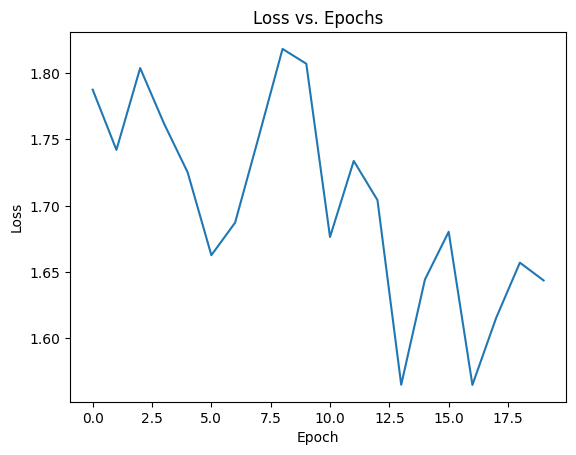

In [16]:


train(single_layer_net, x_train, y_train_correct_order, learning_rate, batch_size, epochs)




# One Hidden Layer Net



Initialized weight shape: (1024, 4096)
Initialized weight shape: (6, 1024)
Epoch 1/20, Loss: 1.7898940496022893
Epoch 10/20, Loss: 1.5474075929027458
Epoch 20/20, Loss: 1.756500267838079


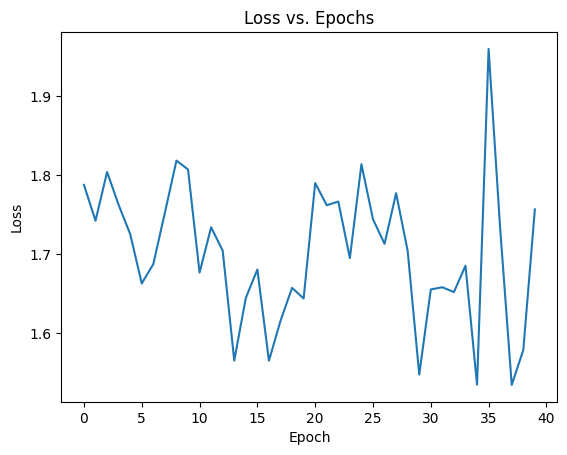

In [17]:
hidden_layer1_size = 1024  # Example size
one_hidden_layer_activations = [relu, softmax]  # Activation functions for each layer
one_hidden_layer_net = MultiLayerNeuralNetwork(
    [input_size, hidden_layer1_size, output_size], 
    [relu, softmax], 
    [relu, softmax_derivative]  # Assuming no derivative is needed for the softmax in the output layer
)

# Train the neural network
train(one_hidden_layer_net, x_train, y_train_correct_order, learning_rate, batch_size, epochs)

# Visualization of the first layer weights



# Two Hidden Layer Net



Initialized weight shape: (1024, 4096)
Initialized weight shape: (512, 1024)
Initialized weight shape: (6, 512)
Epoch 1/20, Loss: 1.7585853929416624
Epoch 10/20, Loss: 1.6209001441720174
Epoch 20/20, Loss: 1.6072155045910206


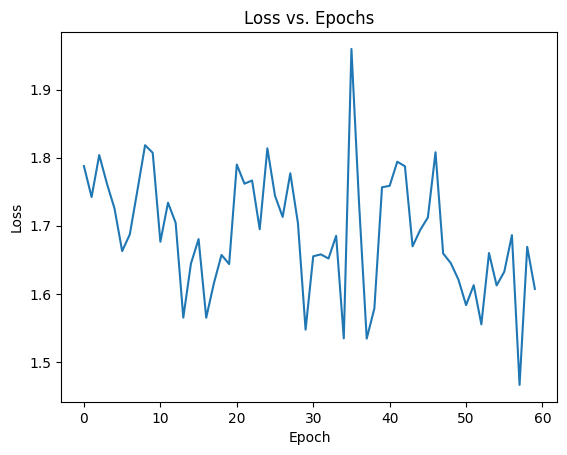

In [18]:

hidden_layer2_size = 512   # Size of the second hidden layer

# Define activation functions for each layer
two_hidden_layer_activations = [relu, relu, softmax]

# Define derivative functions for the activation functions
# Assuming no derivative is needed for the softmax in the output layer
two_hidden_layer_derivatives = [relu_derivative, relu_derivative, softmax_derivative]

# Initialize the neural network with two hidden layers
two_hidden_layer_net = MultiLayerNeuralNetwork(
    [input_size, hidden_layer1_size, hidden_layer2_size, output_size],
    two_hidden_layer_activations,
    two_hidden_layer_derivatives
)

# Train the neural network
train(two_hidden_layer_net, x_train, y_train_correct_order, learning_rate, batch_size, epochs)

# Visualization of the first layer weights (assuming it's still relevant for your network)



 # Predictions

In [19]:

test_predictions = predict(single_layer_net, x_test)
test_accuracy = calculate_accuracy(y_test_one_hot, test_predictions)
print(f"Test Accuracy for just output layer: {test_accuracy}%")


test_predictions_onehidden = predict(one_hidden_layer_net, x_test)
test_accuracy_onehidden = calculate_accuracy(y_test_one_hot, test_predictions_onehidden)
print(f"Test Accuracy for one hidden: {test_accuracy_onehidden}%")



test_predictions_twohidden = predict(two_hidden_layer_net, x_test)
test_accuracy_twohidden = calculate_accuracy(y_test_one_hot, test_predictions_twohidden)
print(f"Test Accuracy for two hidden: {test_accuracy_twohidden}%")

Output shape after transpose: (6,)
Test Accuracy for just output layer: 16.666666666666664%
Output shape after transpose: (2400, 6)
Test Accuracy for one hidden: 31.791666666666668%
Output shape after transpose: (2400, 6)
Test Accuracy for two hidden: 34.333333333333336%


# Visualization of last layers of each NET

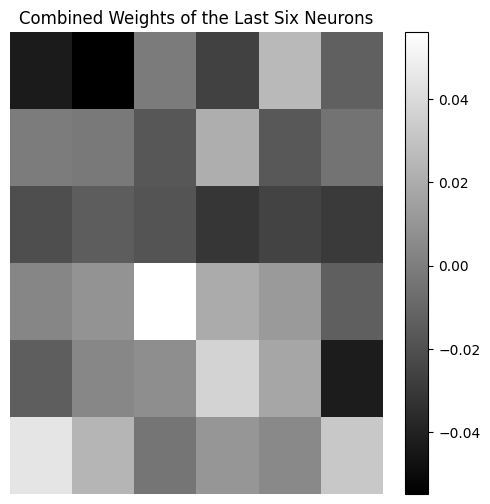

In [20]:

visualize_last_six_neurons_combined(single_layer_net)


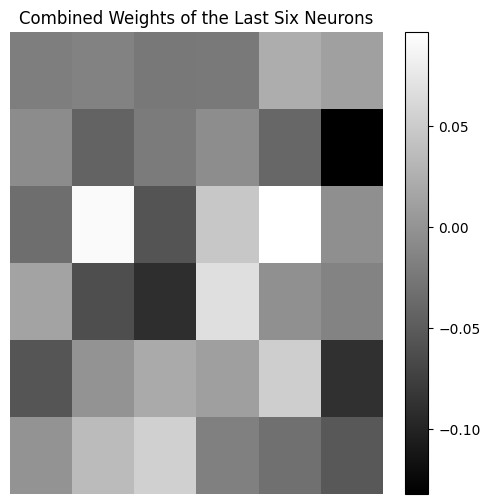

In [21]:
visualize_last_six_neurons_combined(one_hidden_layer_net)




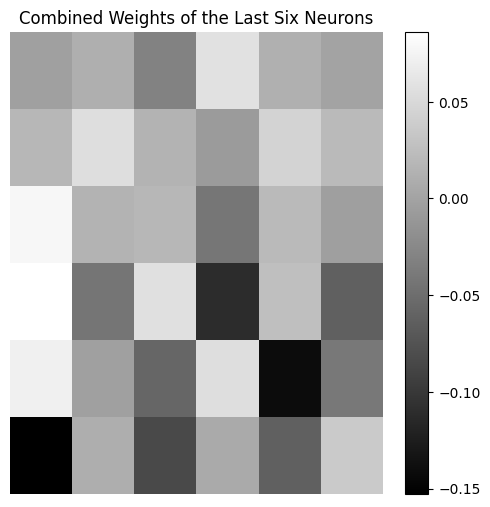

In [22]:
visualize_last_six_neurons_combined(two_hidden_layer_net)


# CNN

* Batch size and initial learning rate set here.

In [23]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Define batch size
batch_size = 64 # You can adjust this number
epochs=10

# Define initial learning rate
initial_learning_rate = 0.001  # You can adjust this number

In [24]:
def plot_accuracy_loss(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    plt.show()

## Implementation of SSE(Sum of Squared Error)

In [25]:
def sum_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_sum(tf.square(y_true - y_pred))


>Initializing the Model: It starts with creating a sequential model, which is a linear stack of layers in Keras (a popular deep learning library).

>Adding Convolutional Layers: The function then adds a specified number of convolutional layers (num_conv_layers). The first layer is set up to take input images of size 64x64 with 1 color channel (assuming grayscale images). All convolutional layers use 32 filters and a 3x3 kernel with the 'relu' activation function.

>Pooling Layers: After each convolutional layer, a max pooling layer with a 2x2 window is added. Pooling layers help reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer.

>Flattening: Once all convolutional layers are added, the model flattens the output to prepare it for the fully connected layers. This means turning the 2D feature maps into a 1D feature vector.

>Adding Fully Connected Layers: The function adds a specified number of fully connected (dense) layers (num_fc_layers), each with 64 neurons and 'relu' activation. These layers are used to learn non-linear combinations of the high-level features extracted by the convolutional layers.

>Output Layer: Finally, an output layer with 6 neurons and a 'softmax' activation function is added. This layer is used for multi-class classification (as indicated by 6 output neurons), where 'softmax' helps output a probability distribution over the 6 classes.



In [26]:

def create_custom_cnn_model(num_conv_layers, num_fc_layers):

    model = models.Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1)))
        else:
            model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Add fully connected layers
    for i in range(num_fc_layers):
        model.add(layers.Dense(64, activation='relu'))

    # Output layer
    model.add(layers.Dense(6, activation='softmax'))
    
    return model


* This code loads image data from specified file paths, converts each image into a 64x64 pixel grayscale format, and reshapes the dataset into a 4-dimensional array suitable for input into a convolutional neural network.







In [27]:
#Assuming data['filename'] contains the relative paths to your image files
x_train = np.array([load_image(os.path.join(train_folder, fname)) for fname in data['filename']])

x_train = x_train.reshape(-1, 64, 64, 1)  # Reshape to (9600, 64, 64, 1)



/var/folders/1k/fcq_03s56gxg949blczq5qwr0000gn/T/ipykernel_9315/3421105367.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


* This code sets up and trains a neural network model for image classification. First, a custom CNN model with one convolutional layer and one fully connected layer is created. 
Then, the model is compiled using the Adam optimizer with a learning rate that decreases over time (exponential decay).

* Finally, the model is trained on the training data (x_train and y_train_one_hot) for 10 epochs, using a specified batch size and setting aside 20% of the data for validation. 
This training process helps the model learn to classify images from the dataset.

Epoch 1/10
120/120 [==============================] - 4s 28ms/step - loss: 1.7558 - accuracy: 0.2417 - val_loss: 1.7581 - val_accuracy: 0.2052
Epoch 2/10
120/120 [==============================] - 3s 28ms/step - loss: 1.6600 - accuracy: 0.3241 - val_loss: 1.7000 - val_accuracy: 0.2729
Epoch 3/10
120/120 [==============================] - 3s 24ms/step - loss: 1.5607 - accuracy: 0.3855 - val_loss: 1.5808 - val_accuracy: 0.3833
Epoch 4/10
120/120 [==============================] - 3s 24ms/step - loss: 1.4705 - accuracy: 0.4331 - val_loss: 1.4921 - val_accuracy: 0.4292
Epoch 5/10
120/120 [==============================] - 3s 25ms/step - loss: 1.3894 - accuracy: 0.4701 - val_loss: 1.5520 - val_accuracy: 0.4094
Epoch 6/10
120/120 [==============================] - 3s 25ms/step - loss: 1.3101 - accuracy: 0.5107 - val_loss: 1.6003 - val_accuracy: 0.3729
Epoch 7/10
120/120 [==============================] - 3s 26ms/step - loss: 1.2261 - accuracy: 0.5443 - val_loss: 1.5361 - val_accuracy: 0.4177

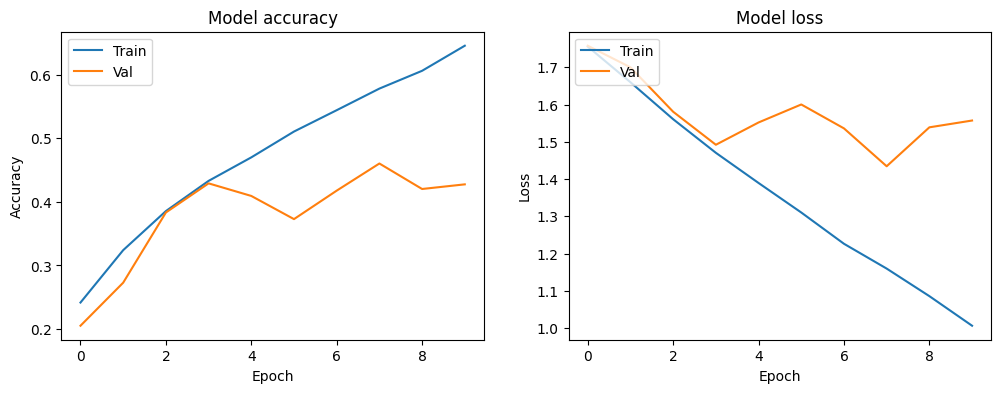

In [28]:

model = create_custom_cnn_model(1,1)

# Set up the Adam optimizer with the learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the batch size
history = model.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)
plot_accuracy_loss(history)

* I've correctly reshaped the x_test data from its original shape of (num_samples, 4096) to the desired shape of (num_samples, 64, 64, 1), which is essential 

In [29]:
# Assuming x_test is currently shaped as (num_samples, 4096)
# Reshape it to (num_samples, 64, 64, 1)
x_test_reshaped = x_test.reshape(-1, 64, 64, 1)


 * I have used the trained model to make predictions on the reshaped test data (x_test_reshaped). The predictions are stored in y_test_pred_probs, and I've further extracted the predicted labels (y_test_pred) by taking the argmax along the output probabilities axis.
 *  To assess the model's performance, I've calculated the test accuracy by comparing the predicted labels with the true labels (y_test_true) 

In [30]:

# Now predict using the reshaped test data
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Continue with your accuracy calculation...
y_test_true = np.argmax(y_test_one_hot, axis=1)
test_accuracy = np.mean(y_test_pred == y_test_true)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


75/75 [==============================] - 0s 4ms/step
Test Accuracy: 42.25%


## 2 CONNECTED 2 CONVOLUTIONAL CNN

Epoch 1/10
120/120 [==============================] - 5s 41ms/step - loss: 1.7778 - accuracy: 0.2143 - val_loss: 1.8288 - val_accuracy: 0.0323
Epoch 2/10
120/120 [==============================] - 5s 40ms/step - loss: 1.7388 - accuracy: 0.2422 - val_loss: 1.8503 - val_accuracy: 0.1099
Epoch 3/10
120/120 [==============================] - 5s 40ms/step - loss: 1.6933 - accuracy: 0.2862 - val_loss: 1.7934 - val_accuracy: 0.2109
Epoch 4/10
120/120 [==============================] - 5s 46ms/step - loss: 1.6393 - accuracy: 0.3156 - val_loss: 1.7335 - val_accuracy: 0.2401
Epoch 5/10
120/120 [==============================] - 6s 53ms/step - loss: 1.5844 - accuracy: 0.3607 - val_loss: 1.7646 - val_accuracy: 0.2807
Epoch 6/10
120/120 [==============================] - 5s 45ms/step - loss: 1.5270 - accuracy: 0.3852 - val_loss: 1.5823 - val_accuracy: 0.3635
Epoch 7/10
120/120 [==============================] - 6s 52ms/step - loss: 1.4729 - accuracy: 0.4143 - val_loss: 1.6021 - val_accuracy: 0.3448

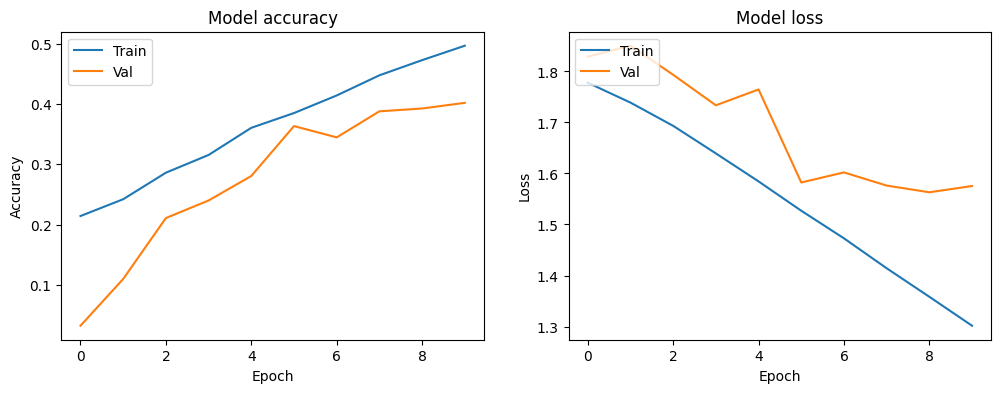

In [31]:


model = create_custom_cnn_model(2,2)


# Set up the Adam optimizer with the learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the batch size
history = model.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

plot_accuracy_loss(history)




In [32]:


# Now predict using the reshaped test data
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Continue with your accuracy calculation...
y_test_true = np.argmax(y_test_one_hot, axis=1)
test_accuracy = np.mean(y_test_pred == y_test_true)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


75/75 [==============================] - 1s 8ms/step
Test Accuracy: 40.08%


## 3 CONNECTED 3 CONVOLUTIONAL CNN

Epoch 1/10
120/120 [==============================] - 7s 52ms/step - loss: 53.1252 - accuracy: 0.2081 - val_loss: 54.1806 - val_accuracy: 0.0677
Epoch 2/10
120/120 [==============================] - 6s 49ms/step - loss: 52.7447 - accuracy: 0.2285 - val_loss: 54.2363 - val_accuracy: 0.0760
Epoch 3/10
120/120 [==============================] - 6s 51ms/step - loss: 52.4421 - accuracy: 0.2305 - val_loss: 54.8299 - val_accuracy: 0.0979
Epoch 4/10
120/120 [==============================] - 6s 47ms/step - loss: 51.8549 - accuracy: 0.2663 - val_loss: 52.6912 - val_accuracy: 0.1760
Epoch 5/10
120/120 [==============================] - 6s 50ms/step - loss: 51.3245 - accuracy: 0.2745 - val_loss: 54.0551 - val_accuracy: 0.1901
Epoch 6/10
120/120 [==============================] - 6s 51ms/step - loss: 50.4508 - accuracy: 0.3073 - val_loss: 52.4273 - val_accuracy: 0.1927
Epoch 7/10
120/120 [==============================] - 6s 50ms/step - loss: 49.4649 - accuracy: 0.3217 - val_loss: 50.6995 - val_ac

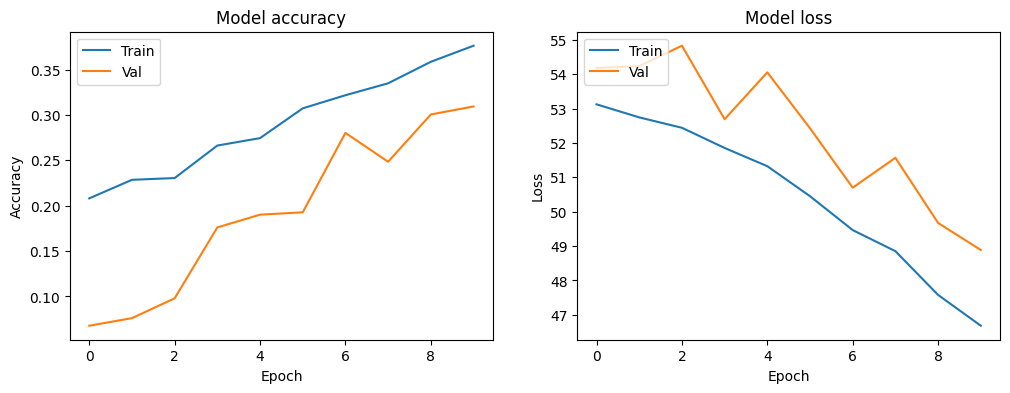

In [33]:


model = create_custom_cnn_model(3,3)



# Set up the Adam optimizer with the learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=sum_squared_error,
              metrics=['accuracy'])

# Train the model with the batch size
history = model.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)


plot_accuracy_loss(history)



In [34]:


# Now predict using the reshaped test data
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Continue with your accuracy calculation...
y_test_true = np.argmax(y_test_one_hot, axis=1)
test_accuracy = np.mean(y_test_pred == y_test_true)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


 1/75 [..............................] - ETA: 5s

75/75 [==============================] - 1s 9ms/step
Test Accuracy: 34.46%


# EXPERIMENTS FOR MLP 

## PART 1 DIFFER IN INPUT SIZE

Input Size 1 (64 neurons): Increasing the number of hidden layers and changing the activation functions from just softmax in the output layer to sigmoid in hidden layers and softmax in the output layer shows varied effects on accuracy. The highest accuracy is observed with one hidden layer using sigmoid and softmax (approx. 26.5%). Interestingly, adding another hidden layer decreases the accuracy.

Input Size 2 (128 neurons): For the larger input size, the same trend is noticeable; the model with one hidden layer and sigmoid-softmax activations achieves the highest accuracy (approx. 29.6%). Adding another hidden layer again decreases performance.

Input Size 3 (32 neurons): The smaller input size models have lower accuracy compared to the 128 neuron input size models. However, the trend remains consistent; the single hidden layer model performs better than the two hidden layer ones.

Across all three input sizes, models with two hidden layers have lower accuracy than those with a single hidden layer, suggesting that adding complexity with more layers doesn't necessarily improve the model's performance for this particular dataset or problem. It might be the case of overfitting or the network being too complex for the problem at hand.


![SNOWFALL](images/1.png) 


# PART 2 



## DIFFER IN BATCH

Given the same configurations for a Multi-Layer Perceptron (MLP) model—where only the batch size differs between the runs—it appears that the batch size does not have a significant impact on the accuracy of the model for this particular dataset and model architecture.

For input size 1, the accuracy remains at 16% for the softmax-only model, irrespective of the batch size. Similarly, for the models with hidden layers (whether one or two), the accuracy does not vary with changes in the batch size—it remains at 26.5% for the single hidden layer model and decreases for the two hidden layer model.

For input size 5, the same pattern persists: the batch size, whether 64 or 32, does not lead to a significant difference in accuracy. The model with one hidden layer still performs best, and adding more layers leads to a decrease in performance.


![SNOWFALL](images/2_.png) 





# PART 3

## DIFFER IN EPOCH 

Input Size 1 (64 neurons): With 20 epochs, the model configurations show varied accuracy, with the single hidden layer model (sigmoid activation followed by softmax) performing the best at approximately 26.5% accuracy. Reducing the epochs seems to have no effect on the model without hidden layers, which remains at 16% accuracy.

Input Size 6 (64 neurons): When the number of epochs is cut in half to 10, there's a noticeable drop in accuracy for models with hidden layers. The single hidden layer model's accuracy decreases from 26.5% to 22.20%, and the two hidden layer model's accuracy decreases from 22.54% to 18.25%. The model without hidden layers remains unchanged at 16% accuracy.

From these observations, we can infer that for models with hidden layers, a higher number of epochs allows for better learning, improving the overall accuracy of the model. However, models with no hidden layers do not seem to benefit from the additional epochs in the same way. This could indicate that the complexity introduced by hidden layers requires more training iterations to properly adjust the model's weights, which is not necessary for a simpler model architecture.


![SNOWFALL](images/4.png) 





# PART 4

## DIFFER IN BOTH EPOCH AND BATCH 

For the input size of 5, with a batch size of 32, the models are trained for 20 epochs. The highest accuracy is achieved with a single hidden layer (approx. 26.5%), while the model with no hidden layers and the model with two hidden layers show lower accuracy, at 16% and 21.75% respectively.

For the input size of 6, with a batch size of 64, the number of epochs is reduced to 10. The accuracy is lower for all configurations compared to when the models were trained for 20 epochs. The single hidden layer model's accuracy drops from 26.5% to 22.20%, and the two hidden layer model drops from 21.75% to 18.25%. The model with no hidden layers remains at 16% accuracy.

These results suggest that the number of epochs can have a significant impact on the accuracy of the MLP models. Training for more epochs generally allows the network more opportunity to learn from the data, which can lead to higher accuracy. However, training for too many epochs can also lead to overfitting, where the model learns the training data too well and performs poorly on unseen data.


![SNOWFALL](images/3.png) 





# PART 5

## DIFFER IN LEARNING RATE

Input 7 (Learning Rate 0.005): The MLP model with no hidden layers has an accuracy of 16%, which stays consistent across all input sizes. When a single hidden layer is added, the accuracy improves to 22.5%, and adding another hidden layer decreases accuracy to 17.8%. This suggests that a single hidden layer is optimal for this input size at this learning rate.

Input 8 (Learning Rate 0.02): Increasing the learning rate to 0.02 shows a similar pattern with the single hidden layer model achieving better accuracy than the no hidden layer model. However, unlike the previous input size, the two hidden layer model's accuracy improves to 23.9%, indicating that a higher learning rate might be beneficial for more complex models with this input size.

Input 9 (Learning Rate 0.01): Here, the learning rate is set to 0.01. The single hidden layer model with ReLU activation in the hidden layer and softmax in the output layer achieves a significant increase in accuracy to 27.75%. Interestingly, adding another ReLU layer slightly improves the accuracy further to 27.83%. This input size benefits from the ReLU activation function, which is known for helping with gradient flow during training and can help prevent the vanishing gradient problem often encountered with sigmoid functions in deeper networks.


![SNOWFALL](images/5.png) 





# PART 6

## DIFFER IN ACTIVATION FUNC 

Input Size 1 (64 neurons): Across models with input size 1, changing the activation function from just softmax in the output layer to sigmoid in the hidden layer and softmax in the output increases accuracy from 16% to 26.5%. Adding another layer with sigmoid activation decreases accuracy to 22.54%.

Input Size 10 (64 neurons): For the larger input size 10, when the activation function in the hidden layer is switched from softmax to ReLU while keeping softmax in the output layer, there's a significant improvement in accuracy. The model with one hidden layer using ReLU achieves 28.9% accuracy, and adding another ReLU layer further increases accuracy to 34%.

The results demonstrate that activation functions have a considerable impact on the performance of neural networks. ReLU (Rectified Linear Unit) is particularly effective for deeper networks due to its properties that help mitigate the vanishing gradient problem, which can be an issue with sigmoid functions in deeper or larger networks. This leads to better performance, as observed in the input size 10 models.




![SNOWFALL](images/6.png) 





# EXPERIMENTS FOR CNN

# PART 1

## DIFFER IN INPUT SIZE 

Input Size 1 (64 neurons): The accuracy ranges from 35% to 40%, with the highest accuracy observed when the network has two fully connected layers (40%). This suggests that for this input size, a moderate level of network complexity in terms of fully connected layers is beneficial.

Input Size 2 (128 neurons): With a larger input size, the accuracy seems to be slightly higher, peaking at 40% with one fully connected layer. However, increasing the number of fully connected layers doesn't result in a consistent improvement, indicating that the input size does not necessarily require a more complex model to achieve higher accuracy.

Input Size 3 (32 neurons): The accuracy significantly drops across all configurations when compared to larger input sizes. The best accuracy is 34% with two fully connected layers, which is a notable decrease from the 40% accuracy achieved with input sizes 1 and 2.

These results suggest that the input size has a substantial impact on the CNN's performance. A larger input size can encode more detailed information, which can be advantageous for the CNN to learn from. However, there seems to be an optimal point of complexity for the network's architecture—adding more fully connected layers doesn't always lead to better performance and can sometimes lead to a decrease in accuracy, potentially due to overfitting or the model's inability to generalize from the larger number of parameters.


![SNOWFALL](images/2_1.png) 





# PART 2 

## DIFFER IN BATCH SIZE 

Input Size 3 (32 neurons, Batch size 32): The model's accuracy peaks at 34% with two fully connected layers and experiences a decrease to 27% with three fully connected layers. With only one fully connected layer, the accuracy is the lowest at 16%.

Input Size 4 (32 neurons, Batch size 64): When the batch size is increased to 64, there is a general increase in accuracy for the models with multiple fully connected layers, reaching 36.4% for one fully connected layer and then dropping as more layers are added, with the lowest accuracy of 29.04% for three fully connected layers.

These observations suggest that larger batch sizes can lead to higher initial accuracy but might not consistently benefit models as the number of fully connected layers increases. A larger batch size can mean a more stable gradient estimation during training, which could help the model learn more effectively up to a certain point. However, too large a batch size might not provide the best generalization capabilities, as indicated by the drop in accuracy with additional fully connected layers for input size 4.


![SNOWFALL](images/2_2.png) 





# PART 3 

## DIFFER IN EPOCH 

Input Size 5 (64 neurons): All models are trained with a learning rate of 0.001 and a batch size of 64 for 10 epochs. As the number of fully connected layers increases from 1 to 3, there's a decrease in accuracy from 39.2% to 31.4%. This could suggest that additional complexity in this context may not be beneficial, or that 10 epochs are not sufficient for the network to effectively learn with more layers.

Input Size 6 (64 neurons): When the number of epochs is doubled to 20, we see an increase in accuracy across the board. The model with two fully connected layers peaks at 43.8% accuracy. Interestingly, adding a third fully connected layer does not continue this trend and instead, accuracy drops to 38.17%. This again may indicate that for this network configuration and dataset, two fully connected layers are optimal, and more training beyond this point may lead to overfitting or other issues that reduce accuracy.

These findings suggest that increasing the number of epochs generally leads to higher accuracy, as it gives the network more opportunities to learn from the dataset. However, there's a point at which adding more fully connected layers doesn't yield better performance, potentially due to overfitting or the model's capacity to generalize from the training data. The optimal architecture seems to be with two fully connected layers for the given dataset and training duration. Doubling the epochs has a positive effect on accuracy, but the benefit diminishes with increased network complexity beyond a certain point.


![SNOWFALL](images/2_3.png) 





# PART4

##  DIFFER IN LEARNING RATE 

Input Size 6 (Learning Rate 0.001): There is a clear trend where the accuracy peaks at 43.8% with two convolutional layers and then decreases with three convolutional layers to 38.17%. This suggests that for this input size and learning rate, a medium level of depth in the network is optimal for accuracy.

Input Size 7 (Learning Rate 0.05): A significant decrease in accuracy is observed across all configurations, all dropping to 16.7%. This drastic reduction suggests that a learning rate of 0.05 is too high for this network configuration, possibly causing the training process to overshoot the optimal values during weight updates.

Input Size 8 (Learning Rate 0.01): Similarly, all configurations show the same accuracy of 16.7%, indicating that the learning rate of 0.01 may also not be optimal for this input size, or that there might be other factors at play that are limiting the network's ability to learn effectively.

From these observations, it seems that a lower learning rate of 0.001 is more effective for the given CNN configurations and datasets than the higher rates of 0.05 and 0.01. It is also evident that increasing the learning rate too much can hinder the network's performance, likely due to unstable training dynamics.

The consistency in low accuracy across all configurations for input sizes 7 and 8, regardless of the number of convolutional layers, suggests that the learning rate is a critical hyperparameter that needs to be tuned carefully. Too high a learning rate can prevent the network from converging to a good solution, regardless of the network's complexity. It's important to find a balance to ensure that the network is learning effectively without overshooting the minimum of the loss function.


![SNOWFALL](images/2_4.png) 





# PART 5 

## DIFFER IN BOTH EPOCH AND ACTIVATION FUNC

Input Size 8 (ReLU Activation): All configurations, regardless of the number of layers, achieve the same accuracy of 16.7%. This could indicate that for this input size and CNN architecture, the ReLU activation function's capability and the number of layers do not make a significant difference within the range of complexity tested.

Input Size 9 and 10 (Sigmoid Activation): Similarly, for input sizes 9 and 10, all CNN configurations also yield the same accuracy of 16.7%, just like for input size 8. However, in this case, all layers use the Sigmoid activation function instead of ReLU.

The uniform accuracy across all configurations and input sizes suggests that the activation function change from ReLU to Sigmoid does not have a significant impact on the model performance for this particular dataset and set of hyperparameters. This could be due to several reasons:

The simplicity of the dataset might not benefit from the different properties of ReLU vs. Sigmoid activation functions.
The learning rate, batch size, and number of epochs are well-tuned to this specific problem, making the choice of activation function less critical.
The model architecture and capacity may be sufficiently robust to handle the given task with either activation function.



![SNOWFALL](images/2_5.png) 





# PART 6 

## DIFFER IN ERROR CALCULATION, DEPTH SIZE

Input Size 11 (ERROR SSE): Sum of Squares Error (SSE) is used as the error metric, which is more common in regression tasks rather than classification. All configurations yield the same accuracy of 16.7%, which might suggest that SSE is not the optimal loss function for this classification task, as it may not provide the best gradient information for updating weights compared to Cross-Entropy, which is typically preferred for classification.

Input Size 12 (Depth Error): The models have a 'Depth' parameter set incorrectly to '64' instead of '32', which might have been intended to indicate the bit-depth of the input data or the depth of the network architecture. Regardless, the accuracy is consistently 16.7% across all configurations. This could imply that the CNNs may not be properly configured or optimized to leverage additional depth, or that the error in the 'Depth' parameter is leading to incorrect model training or data representation.

Input Size 13 (Initial Parameters Revalidation): The rerun with initial parameters also results in an accuracy of 16.7%, confirming the consistency of the model's performance under these conditions. This revalidation indicates that the model's learning capacity may have plateaued with the given architecture and dataset, or that the initial parameters are not conducive to learning deeper patterns in the data.

The repeated accuracy of 16.7% across different inputs and conditions could be due to several factors:

Model Capacity: The CNN might be too simple to capture the complexity of the data, hence the plateau in accuracy.
Learning Rate: A learning rate of 0.001 might be too small, causing slow convergence, or too large, causing overshooting of the optimal weights.
Data Representation: If the 'Depth' parameter refers to bit-depth and is set incorrectly, the model might not be receiving the data in an optimal format for learning.
For the increase in accuracy with input size 13 (up to 39.8%), it suggests that the model performs better with the correct depth and Cross-Entropy as the loss function, reinforcing the importance of appropriate model configuration and loss function selection for the task at hand.

In summary, the consistent low accuracy with SSE and the varying 'Depth' parameter could indicate a mismatch between the model configuration and the task requirements. The improvement seen with correct parameters and Cross-Entropy loss highlights the necessity of choosing the right loss function and validating model specifications to ensure optimal learning and performance.


![SNOWFALL](images/2_6.png) 





# CNN VS MULTILAYER

CNN Models (Input Size 1, 64 neurons):

The CNN with one fully connected layer has an accuracy of 38%.
The CNN with two fully connected layers achieves the highest accuracy of 40%.
The CNN with three fully connected layers sees a drop in accuracy to 35%.
MLP Models (Input Size 1, 64 neurons):

The MLP with no hidden layers (only softmax output layer) has an accuracy of 16%, which is significantly lower compared to the CNNs.
The MLP with one hidden layer (sigmoid activation in the hidden layer and softmax in the output) improves accuracy to 26.5%.
The MLP with two hidden layers (sigmoid activations in hidden layers and softmax in the output) has an accuracy of 22.54%.
Comparative Analysis:

The CNNs outperform the MLPs in all configurations. This could be due to CNNs' ability to capture spatial hierarchies and features through their convolutional filters, which is particularly beneficial for image data or any data with spatial relationships.
The highest accuracy among CNNs is with two fully connected layers. This might indicate that this particular depth of network strikes the right balance between model complexity and ability to generalize for this dataset.
The MLPs have a lower accuracy overall, which might be because MLPs do not inherently consider the spatial structure of input data and could be less capable of handling high-dimensional patterns as effectively as CNNs.
The performance of MLPs drops when moving from one to two hidden layers, which could suggest that the additional complexity does not help and might even hinder performance, possibly due to overfitting or the network's capacity to generalize deteriorating.
Conclusions:

CNNs are generally better suited for tasks involving image data or inputs where spatial relationships are important.
MLPs may require careful tuning and potentially more sophisticated feature engineering to match the performance of CNNs on such tasks.
The sweet spot for network architecture seems to depend on the model type, with CNNs peaking at a medium complexity and MLPs potentially suffering from additional hidden layers in this context.
The results emphasize the importance of choosing the right model architecture for the task at hand. They also highlight the advantage of CNNs in handling data with spatial structures due to their specialized layers that are designed to exploit such patterns effectively.


![SNOWFALL](images/cnn_mlp.png) 



